In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

# New section

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list
from stochastic import random as strandom

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [98]:
SHUFFLE = True
MAX_EPOCHS = 10000
BATCH_SIZE = 1024
PATIENCE = 100
N = 100
T = 200
L = None

NB_INPUT_FEATURES = 1
SEARCH_WIDTH = 2
WINDOW_WIDTHS = [36, 48, 60, 72, 84]
SHIFT_WIDTH = 10

alphas = [0.001, 0.5, 1.0, 1.5, 1.999]
#color_set = ['lightcoral', 'red', 'orange', 'yellow', 'green',  'springgreen', 'royalblue', 'blueviolet', 'magenta']

In [3]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list)

In [4]:
def alphas_2_cps(alpha_seq):
    cp_seq = []
    alpha = alpha_seq[0]
    for next_alpha in alpha_seq[1:]:
        if alpha != next_alpha:
            cp_seq.append(1)
        else:
            cp_seq.append(0)
        alpha = next_alpha
    cp_seq.append(0)
    return np.array(cp_seq)

In [5]:
def make_signal(x_pos, y_pos, win_widths, search_width):
    all_vals = []
    for win_width in win_widths:
        vals = []
        for checkpoint in range(int(win_width/2), len(x_pos) - int(win_width/2)):
            xs = x_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]
            ys = y_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]

            xs1 = xs[:int(len(xs)/2)] - float(xs[:int(len(xs)/2)][0])
            xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])

            ys1 = ys[:int(len(ys)/2)] - float(ys[:int(len(ys)/2)][0])
            ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])

            std_xs1 = np.std(xs1)
            std_xs2 = np.std(xs2)
            std_ys1 = np.std(ys1)
            std_ys2 = np.std(ys2)

            surface_xs1 = abs(np.sum(xs1)) / win_width
            surface_xs2 = abs(np.sum(xs2)) / win_width
            surface_ys1 = abs(np.sum(ys1)) / win_width
            surface_ys2 = abs(np.sum(ys2)) / win_width


            xs1 = np.cumsum(abs(xs1)) #* surface_xs1
            xs2 = np.cumsum(abs(xs2)) #* surface_xs2
            ys1 = np.cumsum(abs(ys1)) #* surface_ys1
            ys2 = np.cumsum(abs(ys2)) #* surface_ys2


            xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
            xs1 = xs1 / xs_max_val
            xs2 = xs2 / xs_max_val
            xs1 = xs1 / win_width
            xs2 = xs2 / win_width

            ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
            ys1 = ys1 / ys_max_val
            ys2 = ys2 / ys_max_val
            ys1 = ys1 / win_width 
            ys2 = ys2 / win_width

            vals.append(abs(np.sum(xs1 - xs2 + ys1 - ys2)) 
                       * (max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                             * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2)))


        vals = np.concatenate((np.zeros(int(win_width/2)), vals))
        vals = np.concatenate((vals, np.zeros(int(win_width/2))))

        vals = np.array(vals)
        all_vals.append(vals)

    new_all_vals = []
    for i in range(len(all_vals)):
        tmp = []
        for j in range(len(all_vals[i])):
            if j < search_width:
                tmp.append(all_vals[i][j] * ((search_width * 2) + 1))
            elif j > len(all_vals[i]) - 1 - search_width:
                tmp.append(all_vals[i][j] * ((search_width * 2) + 1))
            else:
                tmp.append(np.sum(all_vals[i][j-search_width:j+search_width+1]))
        tmp = np.array(tmp)
        new_all_vals.append(tmp)
    new_all_vals = np.array(new_all_vals)
    all_vals = np.array(new_all_vals)

    tmp = []
    for j in range(len(all_vals[0])):
        tmp_sum = 0
        count = 0
        for i in range(len(all_vals)):
            if all_vals[i][j] != 0:
                tmp_sum += all_vals[i][j]
                count += 1
        if count == 0:
            tmp.append(0)
        else:
            tmp.append(tmp_sum / count)
    all_vals = np.array(tmp)
    return all_vals

In [6]:
def chop_with_shift2(signal_seq, label_seq):
    chopped_signals = []
    chopped_labels = []
    for i in range((SHIFT_WIDTH//2), len(signal_seq) - (SHIFT_WIDTH//2)):
        chopped_signals.append(signal_seq[i - (SHIFT_WIDTH//2) : i + (SHIFT_WIDTH//2)])
        chopped_labels.append(label_seq[i])
    return chopped_signals, chopped_labels

In [7]:
def chop_with_shift(signal_seq, changepoints):
    chopped_signals = []
    chopped_labels = []
    for cp in changepoints:
        if cp >= (SHIFT_WIDTH//2) and cp < len(signal_seq) - (SHIFT_WIDTH//2):
            while True:
                random_selec = np.random.randint(0, T)
                if random_selec not in changepoints and random_selec >= (SHIFT_WIDTH//2) and random_selec < len(signal_seq) - (SHIFT_WIDTH//2):
                    chopped_signals.append(signal_seq[random_selec - (SHIFT_WIDTH//2) : random_selec + (SHIFT_WIDTH//2)])
                    chopped_labels.append(0)
                    chopped_signals.append(signal_seq[cp - 3 - (SHIFT_WIDTH//2) : 
                                                      cp - 3 + (SHIFT_WIDTH//2)])
                    chopped_labels.append(0)
                    chopped_signals.append(signal_seq[cp + 3 - (SHIFT_WIDTH//2) : 
                                                      cp + 3 + (SHIFT_WIDTH//2)])
                    chopped_labels.append(0)
                    chopped_signals.append(signal_seq[cp - (SHIFT_WIDTH//2) : cp + (SHIFT_WIDTH//2)])
                    chopped_labels.append(1)
                    break
    return np.array(chopped_signals), np.array(chopped_labels)

In [95]:
input_signals = []
input_labels = []

In [96]:
K_bound = [1e-12, 1000000.0]
alpha_bound = [0, 1.999]


for _ in range(100):
    alpha1, alpha2 = np.random.choice(alphas, 2, replace=True)
    trajs_model, labels_model = models_phenom().multi_state(N=N,
                                                            L=L,
                                                            T=T,
                                                            alphas=[alpha1, alpha2],  # Fixed alpha for each state
                                                            Ds=[[0.1, 0.0], [0.1, 0.0]],# Mean and variance of each state
                                                            M=[[0.99, 0.01], [0.01, 0.99]]
                                                           )
    
    for i in range(N):
        signal_seq = make_signal(trajs_model[:, i, 0], trajs_model[:, i, 1], WINDOW_WIDTHS, SEARCH_WIDTH)
        changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, i, :])
        label_seq = alphas_2_cps(labels_model[:, i, 0])
        
        chop_signal, chop_label = chop_with_shift(signal_seq, changepoints[:-1])
        if len(chop_signal) != 0:
            input_signals.extend(chop_signal)
            input_labels.extend(chop_label)

input_signals = np.array(input_signals)
input_labels = np.array(input_labels)

In [97]:
print(input_signals.shape, input_labels.shape)

(31420, 10) (31420,)


In [99]:
input_signals = input_signals.reshape(-1, SHIFT_WIDTH, 1)
input_labels = input_labels.reshape(-1, 1)
split_index = int(input_signals.shape[0] * 0.8)
train_input = input_signals[:split_index]
train_label = input_labels[:split_index]
val_input = input_signals[split_index:]
val_label = input_labels[split_index:]

In [100]:
train_tf = tf.data.Dataset.from_tensor_slices((train_input, train_label)).batch(BATCH_SIZE)
val_tf = tf.data.Dataset.from_tensor_slices((val_input, val_label)).batch(BATCH_SIZE)
print(train_tf)
print(val_tf)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 10, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 10, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>


In [101]:
class Jaccard(tf.keras.Metric):

    def __init__(self, name='JSC', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_tp'
        )
        self.false_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fp'
        )
        self.false_negatives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fn'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.keras.ops.cast(y_true, "bool")
        y_pred = tf.keras.ops.cast(tf.math.round(y_pred), "bool")

        tp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, True))
        tp_values = tf.keras.ops.cast(tp_values, self.dtype)
        
        fp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, True))
        fp_values = tf.keras.ops.cast(fp_values, self.dtype)
        
        fn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, False))
        fn_values = tf.keras.ops.cast(fn_values, self.dtype)
        
        tn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, False))
        tn_values = tf.keras.ops.cast(tn_values, self.dtype)

        self.true_positives.assign(self.true_positives + tf.keras.ops.sum(tp_values))
        self.false_positives.assign(self.false_positives + tf.keras.ops.sum(fp_values))
        self.false_negatives.assign(self.false_negatives + tf.keras.ops.sum(fn_values))

    def result(self):
        return self.true_positives / (self.true_positives + self.false_positives + self.false_negatives)

In [102]:
def compile_and_fit(model, train_tf, val_tf, patience=100):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True,)
    """
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
    """
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='BinaryAcc'), Jaccard(name='JCP', dtype=None)]
                 ) 
    history = model.fit(x=train_tf,
                        validation_data=val_tf,
                        epochs=MAX_EPOCHS,
                        shuffle=True,
                        callbacks=[early_stopping],
                        verbose=2)
    return history

In [103]:
%%time
lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(512),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, 'sigmoid'),
])

history = compile_and_fit(lstm, train_tf, val_tf, patience=PATIENCE)

Epoch 1/10000
25/25 - 4s - 146ms/step - BinaryAcc: 0.6103 - JCP: 0.4127 - loss: 0.6635 - val_BinaryAcc: 0.6291 - val_JCP: 0.3700 - val_loss: 0.6471
Epoch 2/10000
25/25 - 2s - 73ms/step - BinaryAcc: 0.6329 - JCP: 0.4002 - loss: 0.6455 - val_BinaryAcc: 0.6329 - val_JCP: 0.3840 - val_loss: 0.6408
Epoch 3/10000
25/25 - 2s - 75ms/step - BinaryAcc: 0.6363 - JCP: 0.4114 - loss: 0.6426 - val_BinaryAcc: 0.6380 - val_JCP: 0.3974 - val_loss: 0.6386
Epoch 4/10000
25/25 - 2s - 73ms/step - BinaryAcc: 0.6388 - JCP: 0.4176 - loss: 0.6401 - val_BinaryAcc: 0.6445 - val_JCP: 0.4020 - val_loss: 0.6345
Epoch 5/10000
25/25 - 2s - 73ms/step - BinaryAcc: 0.6425 - JCP: 0.4231 - loss: 0.6343 - val_BinaryAcc: 0.6461 - val_JCP: 0.3988 - val_loss: 0.6302
Epoch 6/10000
25/25 - 2s - 75ms/step - BinaryAcc: 0.6456 - JCP: 0.4241 - loss: 0.6301 - val_BinaryAcc: 0.6491 - val_JCP: 0.4184 - val_loss: 0.6252
Epoch 7/10000
25/25 - 2s - 73ms/step - BinaryAcc: 0.6484 - JCP: 0.4311 - loss: 0.6240 - val_BinaryAcc: 0.6534 - val_J

Epoch 57/10000
25/25 - 2s - 77ms/step - BinaryAcc: 0.6651 - JCP: 0.4732 - loss: 0.5932 - val_BinaryAcc: 0.6692 - val_JCP: 0.4535 - val_loss: 0.5861
Epoch 58/10000
25/25 - 2s - 74ms/step - BinaryAcc: 0.6661 - JCP: 0.4728 - loss: 0.5925 - val_BinaryAcc: 0.6723 - val_JCP: 0.4618 - val_loss: 0.5858
Epoch 59/10000
25/25 - 2s - 73ms/step - BinaryAcc: 0.6661 - JCP: 0.4736 - loss: 0.5941 - val_BinaryAcc: 0.6715 - val_JCP: 0.4661 - val_loss: 0.5846
Epoch 60/10000
25/25 - 2s - 78ms/step - BinaryAcc: 0.6662 - JCP: 0.4750 - loss: 0.5916 - val_BinaryAcc: 0.6677 - val_JCP: 0.4505 - val_loss: 0.5864
Epoch 61/10000
25/25 - 2s - 88ms/step - BinaryAcc: 0.6679 - JCP: 0.4750 - loss: 0.5917 - val_BinaryAcc: 0.6709 - val_JCP: 0.4556 - val_loss: 0.5874
Epoch 62/10000
25/25 - 2s - 87ms/step - BinaryAcc: 0.6673 - JCP: 0.4739 - loss: 0.5913 - val_BinaryAcc: 0.6650 - val_JCP: 0.4437 - val_loss: 0.5901
Epoch 63/10000
25/25 - 2s - 87ms/step - BinaryAcc: 0.6654 - JCP: 0.4718 - loss: 0.5907 - val_BinaryAcc: 0.6680 -

25/25 - 4s - 166ms/step - BinaryAcc: 0.6818 - JCP: 0.4879 - loss: 0.5705 - val_BinaryAcc: 0.6676 - val_JCP: 0.4880 - val_loss: 0.5917
Epoch 113/10000
25/25 - 3s - 138ms/step - BinaryAcc: 0.6819 - JCP: 0.4845 - loss: 0.5702 - val_BinaryAcc: 0.6690 - val_JCP: 0.4631 - val_loss: 0.5961
Epoch 114/10000
25/25 - 3s - 122ms/step - BinaryAcc: 0.6806 - JCP: 0.4826 - loss: 0.5721 - val_BinaryAcc: 0.6679 - val_JCP: 0.4562 - val_loss: 0.5977
Epoch 115/10000
25/25 - 3s - 129ms/step - BinaryAcc: 0.6785 - JCP: 0.4810 - loss: 0.5721 - val_BinaryAcc: 0.6666 - val_JCP: 0.4514 - val_loss: 0.5970
Epoch 116/10000
25/25 - 3s - 128ms/step - BinaryAcc: 0.6795 - JCP: 0.4870 - loss: 0.5684 - val_BinaryAcc: 0.6647 - val_JCP: 0.4801 - val_loss: 0.5953
Epoch 117/10000
25/25 - 3s - 120ms/step - BinaryAcc: 0.6817 - JCP: 0.4871 - loss: 0.5652 - val_BinaryAcc: 0.6703 - val_JCP: 0.4563 - val_loss: 0.5971
Epoch 118/10000
25/25 - 3s - 118ms/step - BinaryAcc: 0.6850 - JCP: 0.4882 - loss: 0.5615 - val_BinaryAcc: 0.6660 - v

Epoch 167/10000
25/25 - 2s - 83ms/step - BinaryAcc: 0.6952 - JCP: 0.5032 - loss: 0.5442 - val_BinaryAcc: 0.6622 - val_JCP: 0.4669 - val_loss: 0.6359
Epoch 168/10000
25/25 - 2s - 84ms/step - BinaryAcc: 0.6914 - JCP: 0.5043 - loss: 0.5564 - val_BinaryAcc: 0.6693 - val_JCP: 0.4684 - val_loss: 0.6255
Epoch 169/10000
25/25 - 2s - 83ms/step - BinaryAcc: 0.6960 - JCP: 0.5066 - loss: 0.5455 - val_BinaryAcc: 0.6692 - val_JCP: 0.4665 - val_loss: 0.6245
Epoch 170/10000
25/25 - 2s - 81ms/step - BinaryAcc: 0.7072 - JCP: 0.5221 - loss: 0.5310 - val_BinaryAcc: 0.6666 - val_JCP: 0.4691 - val_loss: 0.6366
Epoch 171/10000
25/25 - 2s - 85ms/step - BinaryAcc: 0.7106 - JCP: 0.5255 - loss: 0.5240 - val_BinaryAcc: 0.6628 - val_JCP: 0.4607 - val_loss: 0.6461
Epoch 172/10000
25/25 - 2s - 89ms/step - BinaryAcc: 0.7124 - JCP: 0.5248 - loss: 0.5245 - val_BinaryAcc: 0.6615 - val_JCP: 0.4610 - val_loss: 0.6504
Epoch 173/10000
25/25 - 2s - 86ms/step - BinaryAcc: 0.7089 - JCP: 0.5231 - loss: 0.5306 - val_BinaryAcc: 0

TypeError: '>' not supported between instances of 'float' and 'NoneType'

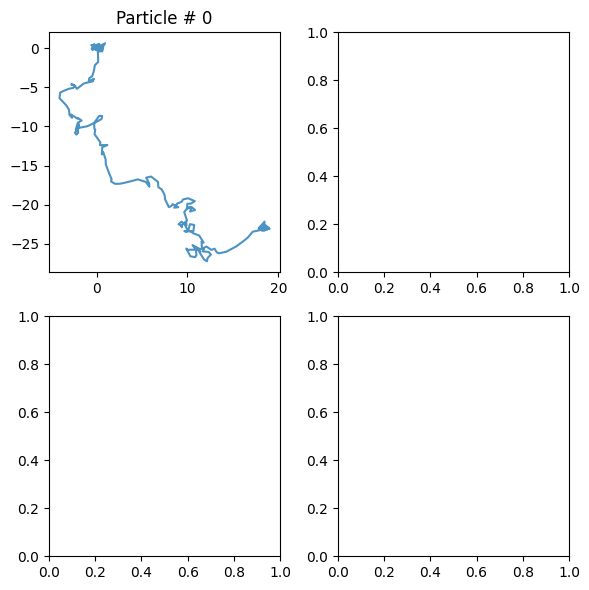

In [137]:
trajs_model, labels_model = models_phenom().multi_state(N=2,
                                                        L=L,
                                                        T=T,
                                                        alphas=[0.1, 1.5],
                                                        Ds=[[0.1, 0.0], [0.1, 0.0]],
                                                        M=[[0.99, 0.01], [0.01, 0.99]]
                                                       )
    
signal_seq = make_signal(trajs_model[:, 0, 0], trajs_model[:, 0, 1], WINDOW_WIDTHS, SEARCH_WIDTH)
changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
plot_trajs(trajs_model[:, 0:2, :], L, 1, num_to_plot =2)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


(-0.05, 20.0)

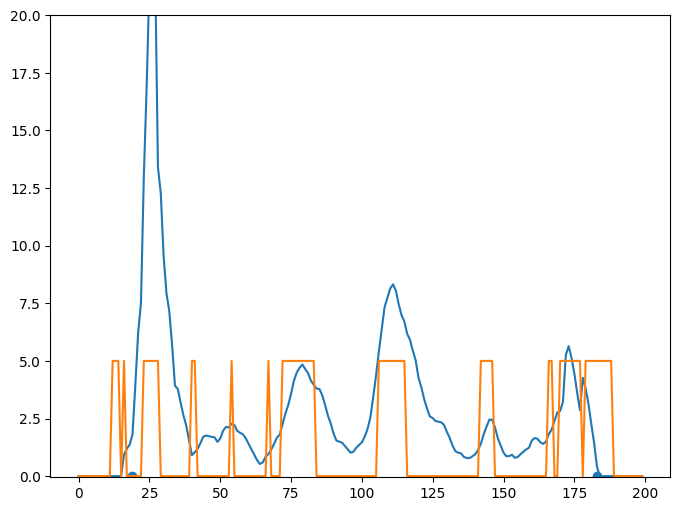

In [138]:
predict_input = []
for i in range(SHIFT_WIDTH//2, len(signal_seq) - SHIFT_WIDTH//2):
    crop = signal_seq[i - SHIFT_WIDTH//2: i + SHIFT_WIDTH//2]
    predict_input.append(crop)
predict_input = np.array(predict_input)
pred = lstm.predict(predict_input).flatten()
pred = np.concatenate((np.zeros(SHIFT_WIDTH//2), pred))
pred = np.concatenate((pred, np.zeros(SHIFT_WIDTH//2)))


plt.figure()
plt.plot(np.arange(T), signal_seq)
plt.plot(np.arange(T), np.round(pred) * np.ones(len(signal_seq)) * 5)
plt.scatter(changepoints[:-1], np.zeros(len(changepoints[:-1])))
plt.ylim([-0.05, 20])

-0.15497478010888918 -0.13491476475643557
0.5972274740633187 0.9962407498079596 0.6163333556484327 0.8225241498962634
-0.08638370462518724 -0.1175112108089167
0.5780873438871487 1.9941021871187694 0.6227748895206643 0.8563508074469781
-0.12169646418362436 -0.17043906408770945
0.7382946004650501 2.7477157510909875 0.6192649267235514 0.8500489738746926
-0.11286347349268415 -0.10022848096681838
0.7763111415657766 3.5175980636305044 0.6826171435414373 0.8456247398280747
-0.09281648393204506 -0.07626174588429181
0.9285039207490962 3.98988337211174 1.0779820297713982 0.8090222752624103
[0.6453421951067125, 0.967121331323955, 1.4924299373426106, 1.1961287695970102, 0.9680887940484967]
-0.0710002652956766


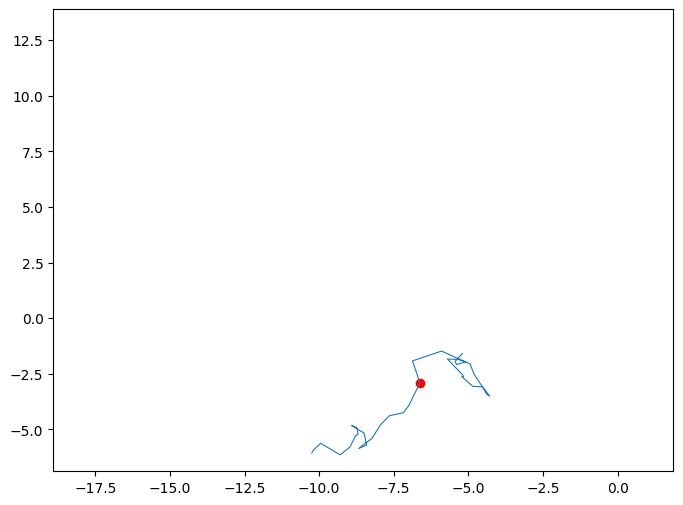

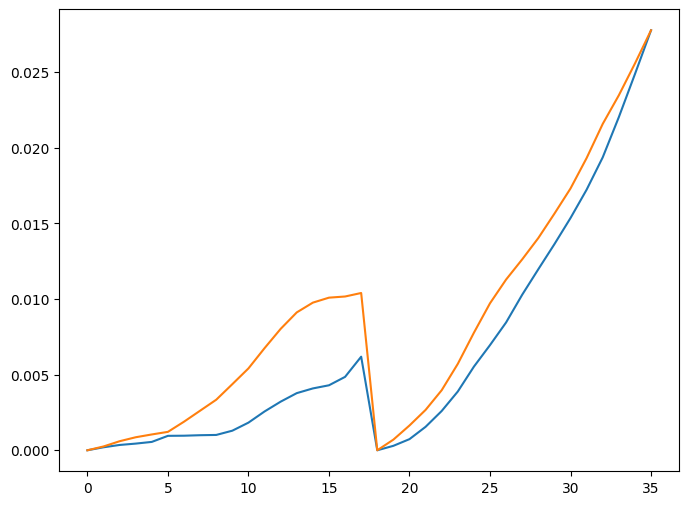

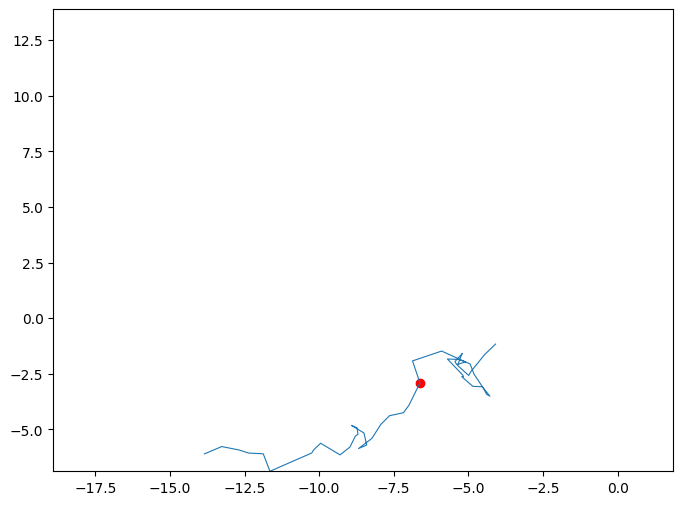

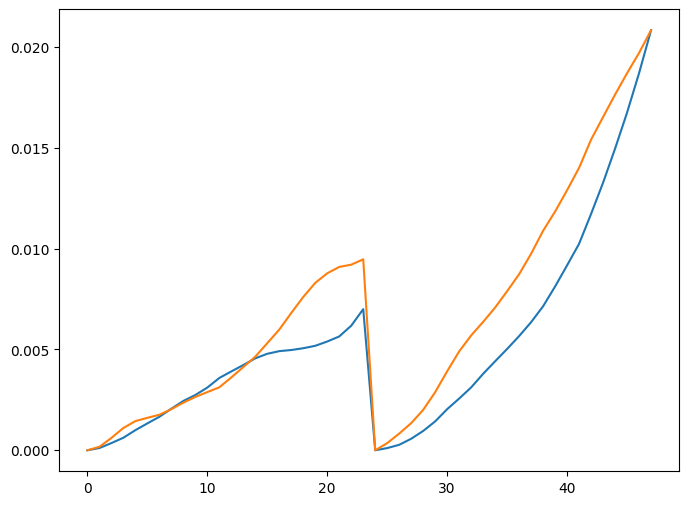

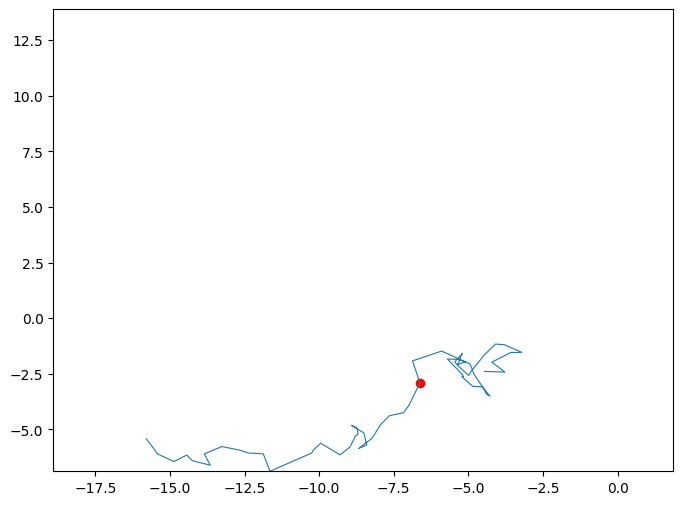

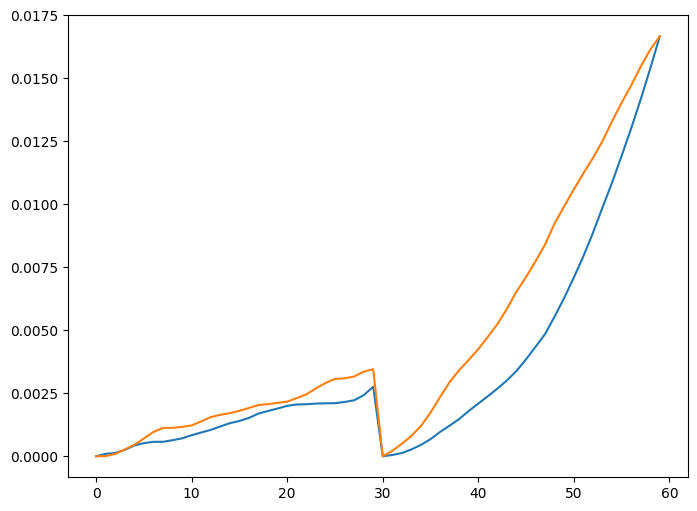

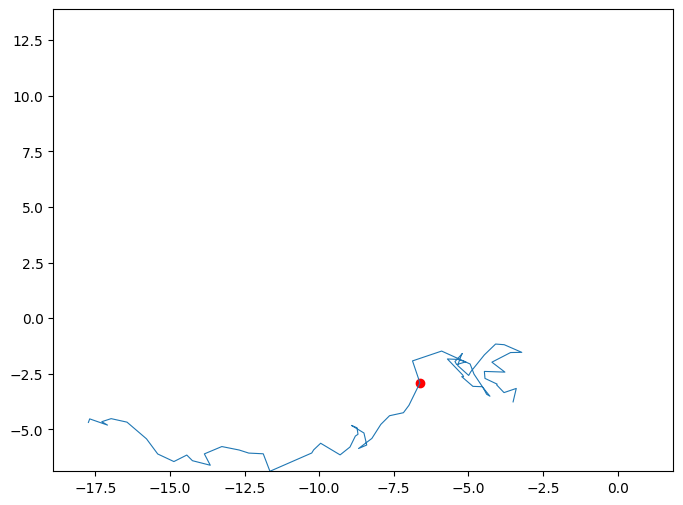

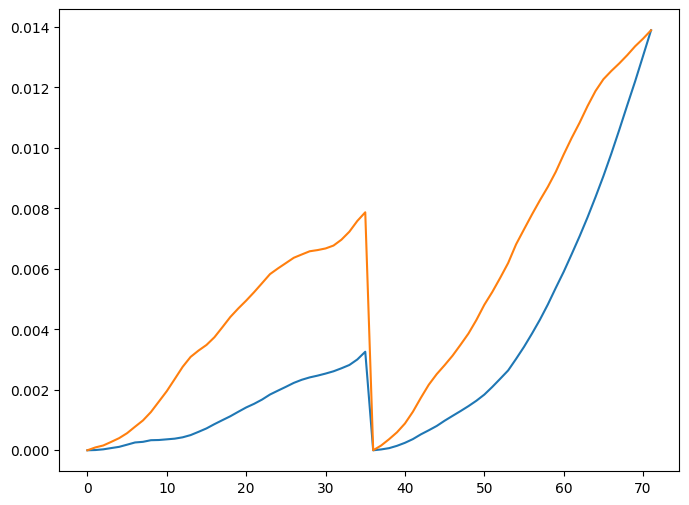

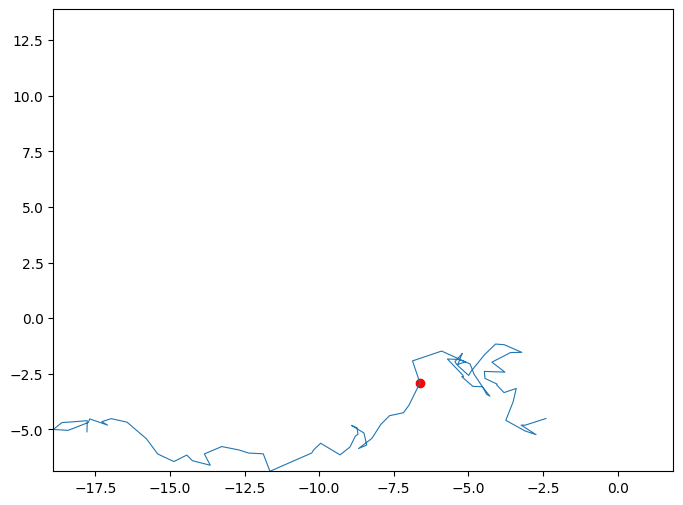

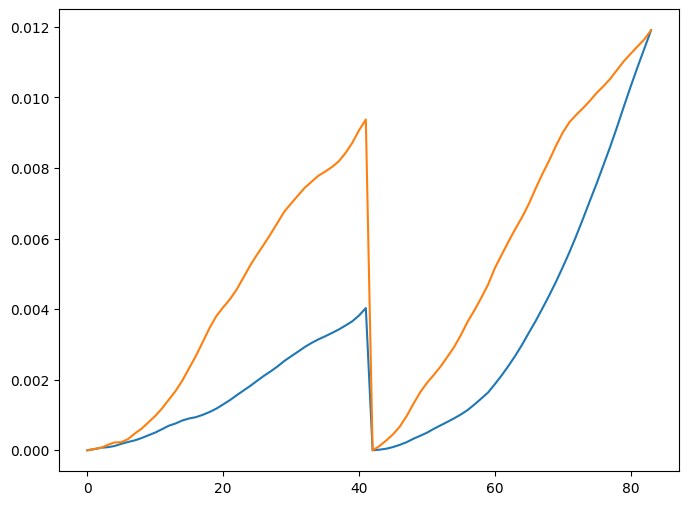

In [47]:
checkpoint = 110
val = []
for WINDOW_WIDTH, c in zip(WINDOW_WIDTHS, COLORS):
    if checkpoint - int(WINDOW_WIDTH/2) >= 0 and checkpoint + int(WINDOW_WIDTH/2) <= len(trajs_model[:, 0, 0]):
        xs = trajs_model[:, 0, 0][checkpoint - int(WINDOW_WIDTH/2) : checkpoint + int(WINDOW_WIDTH/2)]
        ys = trajs_model[:, 0, 1][checkpoint - int(WINDOW_WIDTH/2) : checkpoint + int(WINDOW_WIDTH/2)]

        plt.figure()
        plt.plot(xs, ys, linewidth=0.8)
        plt.scatter(xs[int(WINDOW_WIDTH/2)], ys[int(WINDOW_WIDTH/2)], c='red')

        plt.xlim([np.min(trajs_model[:, 0, 0]),
              np.min(trajs_model[:, 0, 0]) + max(np.max(trajs_model[:, 0, 0]) - np.min(trajs_model[:, 0, 0]), 
                np.max(trajs_model[:, 0, 1]) - np.min(trajs_model[:, 0, 1]))])
        plt.ylim([np.min(trajs_model[:, 0, 1]),
                  np.min(trajs_model[:, 0, 1]) + max(np.max(trajs_model[:, 0, 0]) - np.min(trajs_model[:, 0, 0]), 
                    np.max(trajs_model[:, 0, 1]) - np.min(trajs_model[:, 0, 1]))])


        #xs = xs / (np.std(xs))
        #xs = np.cumsum((uncumulate(xs)))
        #ys = ys / (np.std(ys))
        #ys = np.cumsum((uncumulate(ys)))
        #xs = uncumulate(xs)
        #ys = uncumulate(ys)

        xs1 = xs[:int(len(xs)/2)] - float(xs[:int(len(xs)/2)][0])
        xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])
        #xs1 = abs(xs1)
        #xs2 = abs(xs2)

        ys1 = ys[:int(len(ys)/2)] - float(ys[:int(len(ys)/2)][0])
        ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])

        std_xs1 = np.std(xs1)
        std_xs2 = np.std(xs2)
        std_ys1 = np.std(ys1)
        std_ys2 = np.std(ys2)

        surface_xs1 = abs(np.sum(xs1)) / WINDOW_WIDTH
        surface_xs2 = abs(np.sum(xs2)) / WINDOW_WIDTH
        surface_ys1 = abs(np.sum(ys1)) / WINDOW_WIDTH
        surface_ys2 = abs(np.sum(ys2)) / WINDOW_WIDTH


        xs1 = np.cumsum(abs(xs1)) #* surface_xs1
        xs2 = np.cumsum(abs(xs2)) #* surface_xs2
        ys1 = np.cumsum(abs(ys1)) #* surface_ys1
        ys2 = np.cumsum(abs(ys2)) #* surface_ys2


        xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
        xs1 = xs1 / xs_max_val
        xs2 = xs2 / xs_max_val
        xs1 = xs1 / WINDOW_WIDTH
        xs2 = xs2 / WINDOW_WIDTH

        ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
        ys1 = ys1 / ys_max_val
        ys2 = ys2 / ys_max_val
        ys1 = ys1 / WINDOW_WIDTH 
        ys2 = ys2 / WINDOW_WIDTH


        """
        xs1 = uncumulate(xs1)
        xs2 = uncumulate(xs2)
        ys1 = uncumulate(ys1)
        ys2 = uncumulate(ys2)

        #print((np.sum(xs1 - xs2))**2 + (np.sum(ys1 - ys2))**2)
        vals.append((abs(np.sum(xs1)) - abs(np.sum(xs2)))**2 + (abs(np.sum(ys1)) - abs(np.sum(ys2)))**2)
        """

        #vals.append(((abs(np.sum(xs1)) - abs(np.sum(xs2)))**2 + (abs(np.sum(ys1)) - abs(np.sum(ys2)))**2))
        #vals.append(np.sum((xs1 - ys1)**2 + (xs2 - ys2)**2))
        #val.append(np.sum((xs1 - xs2)**2 + (ys1 - ys2)**2))
        #val.append(abs((xs1[-1]- xs2[-1]) + (ys1[-1] - ys2[-1])))
        #val.append(abs(np.sum(xs1 - xs2) + np.sum(ys1 - ys2)))
        #val.append(abs((surface_xs1 - surface_xs2) + (surface_ys1 - surface_ys2)))
        #val.append(abs((xs1[-1]- xs2[-1]) + (ys1[-1] - ys2[-1])))
        print(np.sum(xs1 - xs2), np.sum(ys1 - ys2))
        print(std_xs1, std_xs2, std_ys1, std_ys2)
        #val.append(abs(np.sum(xs1 - xs2)*(max(std_xs1, std_xs2) - min(std_xs1, std_xs2)) 
        #               + np.sum(ys1 - ys2)*(max(std_xs1, std_xs2) - min(std_xs1, std_xs2))))
        #val.append(abs((np.sum(xs1 - xs2))*(max(std_xs1, std_xs2) - min(std_xs1, std_xs2)) 
        #               + (np.sum(ys1 - ys2))*(max(std_ys1, std_ys2) - min(std_ys1, std_ys2))))
        val.append(abs(np.sum(xs1 - xs2) + np.sum(ys1 - ys2)) 
                   * abs((max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                         * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2))))

        #print((np.sum(xs1 - xs2))**2 + (np.sum(ys1 - ys2))**2)
        #val.append((abs(np.sum(xs1)) - abs(np.sum(xs2)))**2 + (abs(np.sum(ys1)) - abs(np.sum(ys2)))**2)

        #xs1 = xs1 / np.std(xs1)
        #xs2 = xs2 / np.std(xs2)
        #ys1 = ys1 / np.std(ys1)
        #ys2 = ys2 / np.std(ys2)

        #xs1 = np.cumsum(xs1)
        #xs2 = np.cumsum(xs2)
        #ys1 = np.cumsum(ys1)
        #ys2 = np.cumsum(ys2)
        #ys1 = abs(ys1)
        #ys2 = abs(ys2)

        """
        xs1 = xs1 / np.sum(xs1)
        xs2 = xs2 / np.sum(xs2)
        ys1 = ys1 / np.sum(ys1)
        ys2 = ys2 / np.sum(ys2)
        """
        """
        if np.sum(xs1) > np.sum(xs2):
            x_gap = abs(xs1 - xs2)
        else:
            x_gap = abs(xs2 - xs1)

        if np.sum(ys1) > np.sum(ys2):
            y_gap = abs(ys1 - ys2)
        else:
            y_gap = abs(ys2 - ys1)

        print(np.sum((x_gap - np.arange(WINDOW_WIDTH/2)**2/np.max(np.arange(WINDOW_WIDTH/2)**2))**2
                     + (y_gap - np.arange(WINDOW_WIDTH/2)**2/np.max(np.arange(WINDOW_WIDTH/2)**2))**2))
        """

        my_xs = np.concatenate((xs1, xs2))
        my_ys = np.concatenate((ys1, ys2))

        plt.figure()
        plt.plot(np.arange(WINDOW_WIDTH), my_xs )
        plt.plot(np.arange(WINDOW_WIDTH), my_ys )
print(val)
print(np.log(val[0] * val[1] * val[2]))